# Implementing the Monte Carlo Tree Search with Connect X

### Connect X Implementation

For this, we will assume we have a basic working Connect X implementation, which can have a variable number rows/columns and win condition. If you want to see the implementation, check the `Show all code` checkbox at the top.

In [79]:
!pip install tqdm

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
You should consider upgrading via the 'C:\ProgramData\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [80]:
from itertools import groupby, chain
import tqdm
import random
import math

has_tqdm = True

In [81]:
NONE = '.'
BLACK = 'B'
WHITE = 'W'
BLACK_PLAYER = 'BLACK'
WHITE_PLAYER = 'WHITE'

def diagonalsPos(matrix, cols, rows):
    """Get positive diagonals, going from bottom-left to top-right."""
    for di in ([(j, i - j) for j in range(cols)] for i in range(cols + rows - 1)):
        yield [matrix[i][j] for i, j in di if i >= 0 and j >= 0 and i < cols and j < rows]

def diagonalsNeg(matrix, cols, rows):
    """Get negative diagonals, going from top-left to bottom-right."""
    for di in ([(j, i - cols + j + 1) for j in range(cols)] for i in range(cols + rows - 1)):
        yield [matrix[i][j] for i, j in di if i >= 0 and j >= 0 and i < cols and j < rows]


class Connect4:
    def __init__(self, cols=7, rows=6, requiredToWin=4):
        self.cols = cols
        self.rows = rows
        self.win = requiredToWin
        self.turn = BLACK
        self.board = [[NONE] * rows for _ in range(cols)]
        self.game_over = False
        self.move_history = []

    def reset_game(self):
        self.turn = BLACK
        self.board = [[NONE] * self.rows for _ in range(self.cols)]
        self.game_over = False
        self.move_history = []

    def insert(self, column, shadow=False):
        color = self.turn
        c = self.board[column]
        if c[0] != NONE:
            if not shadow:
                self.printBoard()
                print(f'Column {column} is full')
            return False

        i = -1
        while c[i] != NONE:
            i -= 1

        if not shadow:
            c[i] = color
            self.move_history.append(column)

            have_won = self.checkForWin()
            if have_won:
                self.game_over = True
            self.turn = WHITE if self.turn == BLACK else BLACK
        return True

    def getWhoseMove(self):
        return BLACK_PLAYER if self.turn == BLACK else WHITE_PLAYER

    def checkForWin(self):
        w = self.getWinner()
        return w
    
    def getBoardKey(self):
        return str(self.board)

    def getWinningPlayer(self):
        w = self.checkForWin()
        if w is not NONE:
            return BLACK_PLAYER if w == BLACK else WHITE_PLAYER
        
        return None

    def getWinner(self):
        lines = (
            self.board,  # columns
            zip(*self.board),  # rows
            diagonalsPos(self.board, self.cols, self.rows),  # positive diagonals
            diagonalsNeg(self.board, self.cols, self.rows)  # negative diagonals
        )

        for line in chain(*lines):
            for color, group in groupby(line):
                if color != NONE and len(list(group)) >= self.win:
                    return color

        if any([x == NONE for row in self.board for x in row]):
            return None
        return 'draw'

    @staticmethod
    def getRepr(board, rows, cols):
        string = '   ' + '  '.join(map(str, range(cols))) + '\n'
        for y in range(rows):
            string += '  '.join([str(y)] + [str(board[x][y]) for x in range(cols)]) + '\n'

        return string

    @staticmethod
    def get_game_from_history(history, *args, **game_params):
        g = Connect4(*args, **game_params)
        for move in history:
            g.insert(move)
        
        return g

    def undoLastMove(self):
        if len(self.move_history) == 0:
            return
        
        move_removed = self.move_history.pop()
        c = self.board[move_removed]
        i = -1
        while c[i] != NONE and abs(i) < self.rows:
            i -= 1

        if c[i] == NONE:
            turn_found = c[i + 1]
            c[i + 1] = NONE
        else:
            turn_found = c[i]
            c[i] = NONE            

        self.turn = turn_found
        self.game_over = False
        
    def undoMoves(self, moves):
        for _ in range(moves):
            self.undoLastMove()

    def getBoardRepr(self):
        return Connect4.getRepr(self.board, self.rows, self.cols)

    def printBoard(self):
        print(self.getBoardRepr())

    def getValidMoves(self):
        if self.game_over:
            return []

        valid_moves = list(filter(lambda col: self.insert(col, shadow=True), range(self.cols)))
        for c in range(self.cols):
            success = self.insert(c, shadow=True)
        
        return valid_moves

## Playing the game.

### Starting a game

A game is initialized by creating a new `Connect4` object. The constructor signature `def __init__(self, cols=7, rows=6, requiredToWin=4)` tells us that if we don't provide any other options, are game will default to using 7 columns, 6 rows, and a win condition of 4 in a row. We can override each of these options as we please.

### Playing the game

In its current state, this is a manual 2 player game. The colors for each player are black and white. Let's talk about what we can do while playing:
- `getWhoseMove()` -- returns whose move it is (black/white)
- `getValidMoves()` -- returns list of valid columns a player can make their move on (0-indexed)
- `insert(column)` -- plays the `column` as the current player's move
- `printBoard()` -- prints the current board 
- `checkForWin()` -- returns who won, if someone has
- `undoLastMove()` -- undoes the last move

## Let's play a basic game!

Just to test our game, we'll use the default parameters and the following moveset:
```python
Black:
[0, 1, 2, 3]
White:
[0, 1, 2]
```

This should result in a win for black.

## Playing against an Agent

Now let's say we want to play against some automated agent. Well, we probably want something competitive (good at the game). We can make a competitive agent using the [Monte Carlo Tree Search algorithm (MCTS)](https://en.wikipedia.org/wiki/Monte_Carlo_tree_search).

MCTS is comprised of 4 parts: seleciton, expansion, default policy, and back propagation.

Here are the basic steps for the algorithm:
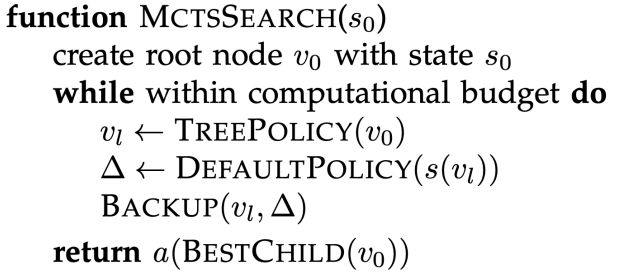


The tree policy call makes up the selection and expansion. The computational budget can be represented by the number of times we are okay with running through the loop to do the 4 parts.

### Tree Policy

During the tree policy, we return the next node to expand, starting from the root node. We want to eventually end with a lead node. We are continuously building up and expanding our tree during this time. The general steps for this are:
- Check if our current node leads to a finished state. If so, we are done since this node cannot be further expanded
- Check if we have expanded all possible child nodes
  - If not, find and add a new child node of our current nodeto the tree. This node has NOT been expanded yet so it's a leaf so we are done
- If we have expanded all children, find the child that seems best to go down to (this is done using a formula)
- Recursively call tree policy of that new best child

### Selecting the best child
This is often done through a formula called the UCB (upper confidence bound). The formula looks like:
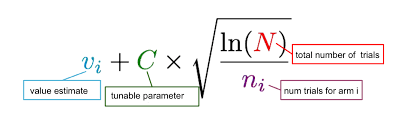

The part to focus on here is `C`, which is tunable and usually is figured out empirically.

### Default Policy

In Minimax, it tries all possible combinations until it hits its max depth. One problem with this is that in games with a high branching factor, where each move can have tons and tons of other moves still, it can take a very long time to even simulate all possible combinations of just a few moves. MCTS addresses this by doing selection and expansion and then **simulating** (default policy) the rest of the game. It does this via random rollout. From the selected node, it randomly plays moves until the game reaches a finished state. When it does this over enough iterations, MCTS can develop a good sense of what moves are better than other by checking the resulting outcomes of the random rollouts from that particular move.

The general steps are:
1. Check if the game is finished. If so, that's our score for the default policy (the random rollout)
2. If not, randomly select a possible move and make that move.
3. Repeat steps 1) and 2) until eventually the game is finished

### Back Propagation

Now that we have reached a terminal state in the game (no more moves left), we need to update the nodes from the selection one to the root with how it did. During this, we increment the count of each node in that path and increment whether player 1 or player 2 won. This is simple-ish in Python:
```python3
node.count += 1
if score > 0:
    node.max_wins += 1
elif score < 0:
    node.min_wins += 1

if node.parent is not None:
    backup(node.parent, score)
```

The general algorithm can be viewed as:
![mcts visualization](https://www.researchgate.net/profile/Diego-Perez-Liebana/publication/274485244/figure/fig1/AS:294858334982145@1447311113569/MCTS-algorithm-steps.png)

## Choosing Optimally

<qinline>

<question>

### Answer this before reading on!

Minimax is an algorithm that, when the depth limit is equal to the number of possible moves, enumerates each game state. However, this may not be realistic in a game. For what games/types of games would MCTS possibly outperform Minimax and why?

</question>

<answer>

Games with high branching factors, like Go, may benefit from using MCTS over Minimax. Minimax will take too long with a high depth to evaluate good options and decreasing the depth means more reliance on how good the evaluation function is for Minimax. Using random rollout can yield better results since it can play deeper into the game to see how good an original move may be.

</answer>

</qinline>

## Here's our implementation of MCTS

This implementation draws inspiration from a lab in our class (CSC 480 - Artificial Intelligence with Dr. Rodrigo Canaan).

In [82]:
def mcts(game, player: str, iterations: int, quiet=False, c=1):
    key = game.getBoardKey()
    start_node = _MCTS_Node(None, 0, None, player)
    lookahead = _Game_Lookahead(game)
    iter = range(iterations)
    if not quiet and has_tqdm:
        iter = tqdm.tqdm(iter, desc='Calculating Monte-Carlo')
    for _ in iter:
        node = _tree_policy(lookahead, start_node, c)
        value = _default_policy(lookahead)
        lookahead.undoMoves(lookahead.depth)
        _backup(node, value)
        assert key == game.getBoardKey()
    action = _best_child(start_node, 0).move
    return action

def _next_player(player):
    if player == 'max':
        return 'min'
    elif player == 'min':
        return 'max'
    else:
        raise ValueError('Unknown player "{}"'.format(player))

class _Game_Lookahead:
    def __init__(self, game, depth = 0):
        self.game = game
        self.depth = depth

    def doMove(self, move: str):
        self.depth += 1
        self.game.insert(move)
    
    def undoMoves(self, moveCount: int):
        self.depth = max(0, self.depth - moveCount)
        self.game.undoMoves(moveCount)

class _MCTS_Node:
    def __init__(self, move, depth, parent, player):
        self.min_wins = 0
        self.max_wins = 0
        self.count = 0
        self.move = move
        self.parent = parent
        self.children = {}
        self.player = player
        self.depth = depth
    
    def add_child(self, move):
        if move in self.children:
            raise ValueError('Child already exists')
        else:
            self.children[move] = _MCTS_Node(move, self.depth + 1, self, _next_player(self.player))
            return self.children[move]
    
    def _get_p_win(self, player):
        if self.count == 0:
            raise ValueError("Must be updated at least once to get win probability")
        if player == 'min':
            return self.min_wins / self.count
        elif player == 'max':
            return self.max_wins / self.count
        else:
            raise ValueError('Unknown player "{}"'.format(player))
    
    def _get_expected_value(self):
        if self.count == 0:
            raise ValueError("Must be updated at least once to get expected value")
        return (self.max_wins - self.min_wins) / self.count

    def _get_explore_term(self, parent, c=1):
        if parent is not None:
            return c * math.sqrt(2 * math.log(parent.count) / self.count)
        else:
            return 0

    def get_ucb(self, c):
        if self.count == 0:
            raise ValueError("Must be updated at least once to calculate UCB")
        p_win = self._get_expected_value()
        if self.player == "max":
            p_win *= -1
        explore_term = self._get_explore_term(self.parent, c)
        return p_win + explore_term
    
def _expand(game: _Game_Lookahead, node):
    # Make sure the game state is at the current node
    assert game.depth == node.depth
    for move in game.game.getValidMoves():
        child = None
        try:
            child = node.add_child(move)
        except ValueError:
            continue
        return child
    
    return None


def _best_child(node, c):
    return max(node.children.values(), key=lambda child: child.get_ucb(c))


def _tree_policy(game: _Game_Lookahead, node, c):
    assert game.depth == node.depth

    if game.game.getWinner() is not None:
        return node
    
    unexplored_child = _expand(game, node)
    if unexplored_child is not None:
        game.doMove(unexplored_child.move)
        return unexplored_child
    else:
        next = _best_child(node, c)
        game.doMove(next.move)
        return _tree_policy(game, next, c)

def _backup(node, winner):
    if node is None:
        return
    node.count += 1
    if winner == 'min':
        node.min_wins += 1
    elif winner == 'max':
        node.max_wins += 1
    _backup(node.parent, winner)

def _default_policy(game: _Game_Lookahead):
    def w_helper():
        temp_winner = game.game.getWinner()
        if temp_winner != BLACK and temp_winner != WHITE:
            return temp_winner
        return 'max' if temp_winner == BLACK else 'min'
    
    winner = w_helper()
    
    while winner is None:
        game.doMove(random.choice(game.game.getValidMoves()))
        winner = w_helper()
    return winner

## Testing MCTS
Now let's test how MCTS does against itself.

In [83]:
def run_mcts_game(move_history, requiredToWin=3, cols=3, rows=4, iters=250, c=1):
    game = Connect4.get_game_from_history(move_history, requiredToWin=requiredToWin, cols=cols, rows=rows)
    game.printBoard()

    # Let's test MCTS
    runs = 0
    while len(game.getValidMoves()) > 0:
        player = game.getWhoseMove()
        best_move = mcts(game, "max" if player == BLACK_PLAYER else "min", iterations=iters, c=c)
        game.insert(best_move)
        print(player, 'played', best_move)
        runs += 1
    
    print()
    game.printBoard()
    print('Winner:', game.getWinningPlayer())

In [84]:
run_mcts_game([0, 1, 2, 0, 2, 1, 1, 1])

   0  1  2
0  .  W  .
1  .  B  .
2  W  W  B
3  B  W  B



Calculating Monte-Carlo: 100%|█████████████████████████████████████████████████████| 250/250 [00:00<00:00, 6250.27it/s]

BLACK played 2

   0  1  2
0  .  W  .
1  .  B  B
2  W  W  B
3  B  W  B

Winner: BLACK


Now let's change up the depth and number of iterations. Given no one immediately wins and we see chains of 2 blocked, we can see that MCTS is playing at least better than randomly. Let's play some more games.

In [73]:
has_tqdm = False
run_mcts_game([0, 1])

   0  1  2
0  .  .  .
1  .  .  .
2  .  .  .
3  B  W  .

BLACK played 1
WHITE played 0
BLACK played 1
WHITE played 1
BLACK played 0
WHITE played 2
BLACK played 0
WHITE played 2
BLACK played 2

   0  1  2
0  B  W  .
1  B  B  B
2  W  B  W
3  B  W  W

Winner: BLACK


In [75]:
run_mcts_game([], rows = 6, cols = 7, requiredToWin=4, iters=50)

   0  1  2  3  4  5  6
0  .  .  .  .  .  .  .
1  .  .  .  .  .  .  .
2  .  .  .  .  .  .  .
3  .  .  .  .  .  .  .
4  .  .  .  .  .  .  .
5  .  .  .  .  .  .  .

BLACK played 1
WHITE played 4
BLACK played 4
WHITE played 2
BLACK played 3
WHITE played 0
BLACK played 3
WHITE played 1
BLACK played 6
WHITE played 3
BLACK played 3
WHITE played 6
BLACK played 3
WHITE played 1
BLACK played 4
WHITE played 1
BLACK played 1
WHITE played 1
BLACK played 6
WHITE played 0
BLACK played 2
WHITE played 0
BLACK played 6
WHITE played 0

   0  1  2  3  4  5  6
0  .  W  .  .  .  .  .
1  .  B  .  B  .  .  .
2  W  W  .  B  .  .  B
3  W  W  .  W  B  .  B
4  W  W  B  B  B  .  W
5  W  B  W  B  W  .  B

Winner: WHITE


In [76]:
run_mcts_game([], rows = 6, cols = 7, requiredToWin=4, iters=150)

   0  1  2  3  4  5  6
0  .  .  .  .  .  .  .
1  .  .  .  .  .  .  .
2  .  .  .  .  .  .  .
3  .  .  .  .  .  .  .
4  .  .  .  .  .  .  .
5  .  .  .  .  .  .  .

BLACK played 3
WHITE played 4
BLACK played 3
WHITE played 3
BLACK played 0
WHITE played 2
BLACK played 3
WHITE played 1
BLACK played 2
WHITE played 4
BLACK played 1
WHITE played 2
BLACK played 0

   0  1  2  3  4  5  6
0  .  .  .  .  .  .  .
1  .  .  .  .  .  .  .
2  .  .  .  B  .  .  .
3  .  .  W  W  .  .  .
4  B  B  B  B  W  .  .
5  B  W  W  B  W  .  .

Winner: BLACK


In [78]:
run_mcts_game([], rows = 6, cols = 7, requiredToWin=4, iters=50, c=3)

   0  1  2  3  4  5  6
0  .  .  .  .  .  .  .
1  .  .  .  .  .  .  .
2  .  .  .  .  .  .  .
3  .  .  .  .  .  .  .
4  .  .  .  .  .  .  .
5  .  .  .  .  .  .  .

BLACK played 2
WHITE played 2
BLACK played 0
WHITE played 1
BLACK played 2
WHITE played 2
BLACK played 1
WHITE played 3
BLACK played 0
WHITE played 3
BLACK played 1
WHITE played 6
BLACK played 1
WHITE played 1
BLACK played 3
WHITE played 3
BLACK played 0

   0  1  2  3  4  5  6
0  .  .  .  .  .  .  .
1  .  W  .  .  .  .  .
2  .  B  W  W  .  .  .
3  B  B  B  B  .  .  .
4  B  B  W  W  .  .  .
5  B  W  B  W  .  .  W

Winner: BLACK


Changing `c` and `iters` changes how MCTS will play. The more iterations, the more likely MCTS will perform better.